In [896]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.6f}'.format  

# 그래프에서 한글 깨짐 방지
import platform
if platform.system() == "Darwin":          # MAC인 경우
    plt.rc('font', family ="AppleGothic")
else:
    plt.rc('font',family='Malgun Gothic')

#멧플로립에서 음수를 표시
plt.rc('axes',unicode_minus=False)

#워닝 메시지
import warnings
warnings.filterwarnings('ignore')


In [897]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [898]:
df=pd.read_csv('./datasets/원본data.csv',index_col=0)
df=df.drop(['원위안', '유가', '은', '외환보유액'],axis=1) # G7 이미 삭제된 데이터셋
dataset=df.values
scaler=StandardScaler()
dataset= scaler.fit_transform(dataset)
print(dataset)

[[ 0.93589755  1.43327182 -0.74157178 ...  2.07114449 -1.74913464
  -1.49457805]
 [ 0.80523213  1.42294476 -0.75485022 ...  2.01342627 -1.57284691
  -1.75012721]
 [ 0.7220814   1.26803893 -0.75485022 ...  2.85611229 -1.33988349
  -1.81061445]
 ...
 [-1.58238152 -0.73540982  0.37381684 ... -0.75285063  1.76937084
  -0.3938106 ]
 [-1.61801754 -0.73540982 -0.40961088 ... -0.59701144  1.4817088
  -0.27075728]
 [-1.66553224 -0.61148516 -0.3432187  ... -0.94751845  1.95422583
  -0.27316174]]


In [899]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)



In [900]:
past_history = 2
future_target = 1
STEP = 1

X_train, y_train = multivariate_data(dataset, dataset[:, -1], 0, 148, past_history,
                                                   future_target, STEP, single_step=False)
X_test, y_test = multivariate_data(dataset, dataset[:, -1], 148, None, past_history,
                                               future_target, STEP, single_step=False)

print('Single window of past history : {}'.format(X_train[0].shape))

Single window of past history : (2, 18)


Epoch 1/180
5/5 [==============================] - 8s 35ms/step - loss: 1.1138
Epoch 2/180
5/5 [==============================] - 0s 29ms/step - loss: 1.0270
Epoch 3/180
5/5 [==============================] - 0s 29ms/step - loss: 0.8369
Epoch 4/180
5/5 [==============================] - 0s 33ms/step - loss: 0.5483
Epoch 5/180
5/5 [==============================] - 0s 33ms/step - loss: 0.3571
Epoch 6/180
5/5 [==============================] - 0s 33ms/step - loss: 0.2128
Epoch 7/180
5/5 [==============================] - 0s 32ms/step - loss: 0.1506
Epoch 8/180
5/5 [==============================] - 0s 31ms/step - loss: 0.1252
Epoch 9/180
5/5 [==============================] - 0s 31ms/step - loss: 0.1286
Epoch 10/180
5/5 [==============================] - 0s 30ms/step - loss: 0.0964
Epoch 11/180
5/5 [==============================] - 0s 41ms/step - loss: 0.0755
Epoch 12/180
5/5 [==============================] - 0s 38ms/step - loss: 0.0837
Epoch 13/180
5/5 [==============================]

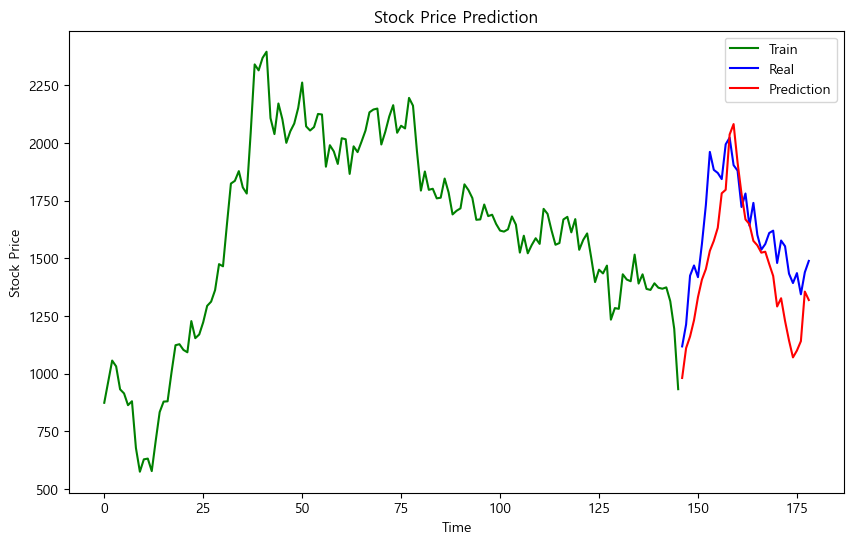

In [901]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), dropout=0.23,recurrent_dropout =0.18,activation='relu'))
model.add(LSTM(64, return_sequences=True, dropout=0.23, recurrent_dropout=0.18,activation='tanh'))
model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.15,activation='tanh'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
history=model.fit(X_train, y_train, epochs=180, batch_size=30, verbose=1)

# 예측
train_predict = model.predict(X_train)
val_predict = model.predict(X_test)

scaler_y = StandardScaler()
scaled_data_y = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1,1))
# 예측 값 스케일 역변환
train_predict = scaler_y.inverse_transform(train_predict)
val_predict = scaler_y.inverse_transform(val_predict)

# 실제 값 스케일 역변환
y_train = scaler_y.inverse_transform(y_train.reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1))


import matplotlib.pyplot as plt


plt.figure(figsize=(10,6))
# Add the training set to the plot:
plt.plot(y_train, color='green', label='Train')
# Plot the test and prediction data:
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), val_predict, color='red', label='Prediction')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


## 학습한 모델 저장 및 불러오기

In [902]:
# model.save('models/LSTM_6_26.h5') 
# 모델을 컴퓨터에 저장
# del model # 테스트를 위해 메모리 내의 모델을 삭제
# models = tf.keras.models.load_model('C:\Users\dgh06\OneDrive\문서\GitHub\project1_time_series\models\LSTM_6_26.h5') # 모델을 새로 불러옴

In [903]:
# import tensorflow as tf

# def lrp(model, x, y, epsilon=1e-7):
#     # 모델의 입력과 출력을 텐서로 변환
#     x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
#     y_tensor = tf.convert_to_tensor(y, dtype=tf.float32)

#     with tf.GradientTape() as tape:
#         tape.watch(x_tensor)
#         predictions = model(x_tensor)  # 모델의 예측 결과 계산
#         loss = tf.keras.losses.mean_squared_error(y_tensor, predictions)  # 손실 함수 계산

#     # 예측값에 대한 LRP 계산
#     gradients = tape.gradient(loss, x_tensor)
#     relevance = x_tensor * gradients

#     # 정규화
#     sum_relevance = tf.reduce_sum(relevance, axis=-1, keepdims=True)
#     normalized_relevance = relevance / (sum_relevance + epsilon)

#     return normalized_relevance.numpy()


In [904]:
lrp

<function __main__.lrp(model, X)>

In [912]:
import tensorflow as tf
import numpy as np

def lrp(model, X):
    model_wo_relu = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].output)
    input_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        output = model_wo_relu(input_tensor)
        gradients = tape.gradient(output, input_tensor)

    relevance = tf.reduce_sum(gradients * input_tensor, axis=-1)
    relevance /= tf.reduce_sum(output, axis=-1, keepdims=True)
    
    return relevance.numpy()

# LRP를 사용하여 각 피처의 중요도 계산
feature_importance = lrp(model, X_train)

# 중요도를 기준으로 내림차순으로 피처 정렬
sorted_features = np.argsort(feature_importance)[::-1]

# 피처 중요도 출력
for idx in sorted_features:
    print(f"Feature {idx}: Importance {feature_importance[idx]}")




#


Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [0 1]: Importance [[ 0.14833012  0.02038951]
 [ 0.1312149  -0.00228994]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[ 0.1312149  -0.00228994]
 [ 0.14833012  0.02038951]]
Feature [1 0]: Importance [[